In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
#pip install skforecast

In [38]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

In [39]:
# Datos
# ==============================================================================
df = pd.read_csv('calidadAireURDECON.csv',";",index_col=0,squeeze=True)
df = df[["pm25","pm10","co2","humedad","temperatura","presencia"]]# Quito la última columna
#df = df[["pm25","pm10","co2","humedad","temperatura"]]
df = df[["co2"]]# Solo dejo el CO2 porque vamos a jugar con una sola variable
df = df.drop_duplicates(subset=['co2'], keep="last")  # Elimino los duplicados 
df = df.set_index(pd.to_datetime(df.index, format='%d-%m-%Y %H:%M:%S')) # Transformo el index en DateTime
#df = df.asfreq('5min')
#Los registros van de cada 5 minutos. 12 Registros = 1 hora. 48Registros = 4 horas 
df = df[:-48] #Me guardo las últimas 4 horas para la predicción
dfUltimas7Horas = df[-48:]
df.head()

,co2
fecha,
2021-10-05 10:39:17,134.77887
2021-10-05 10:44:17,139.66228
2021-10-05 10:49:17,159.06667
2021-10-05 10:54:17,121.99109
2021-10-05 10:59:18,116.49886


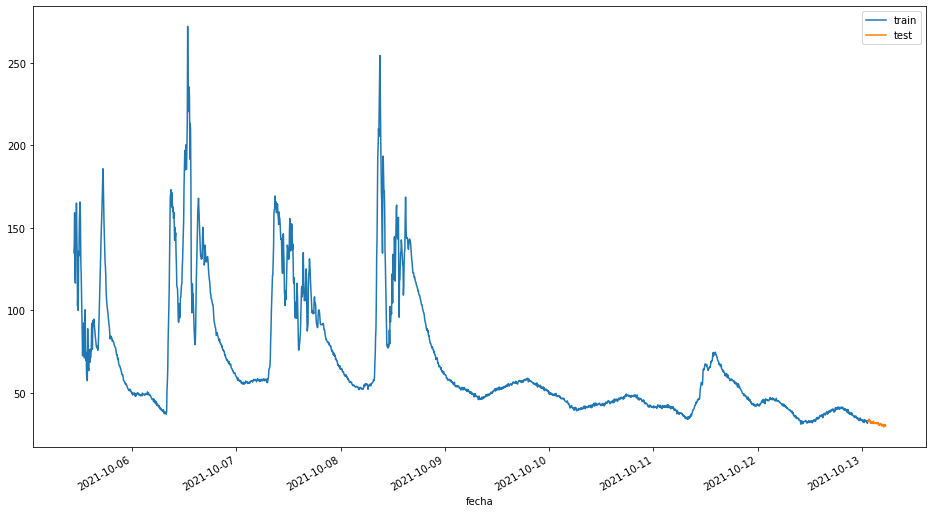

In [40]:
# Preparo datos para el modelo, solo dejo el CO2
# ==============================================================================
df = df['co2']
# Separo Train y Test
# ==============================================================================
steps = 48
datos_train = df[:-steps]
datos_test  = df[-steps:]
fig, ax=plt.subplots(figsize=(16, 9))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

# Modelo

In [41]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=123),
                    lags=6
                )

forecaster_rf.fit(y=datos_train)

forecaster_rf



=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=123)
Lags: [1 2 3 4 5 6]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

# Prediccion


In [42]:
# Predicciones
# ==============================================================================
steps = 48
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)
predicciones.head()

fecha
2021-10-13 01:22:33    32.013362
2021-10-13 01:27:47    32.471648
2021-10-13 01:33:01    32.428232
2021-10-13 01:37:35    32.717478
2021-10-13 01:42:49    32.684622
dtype: float64

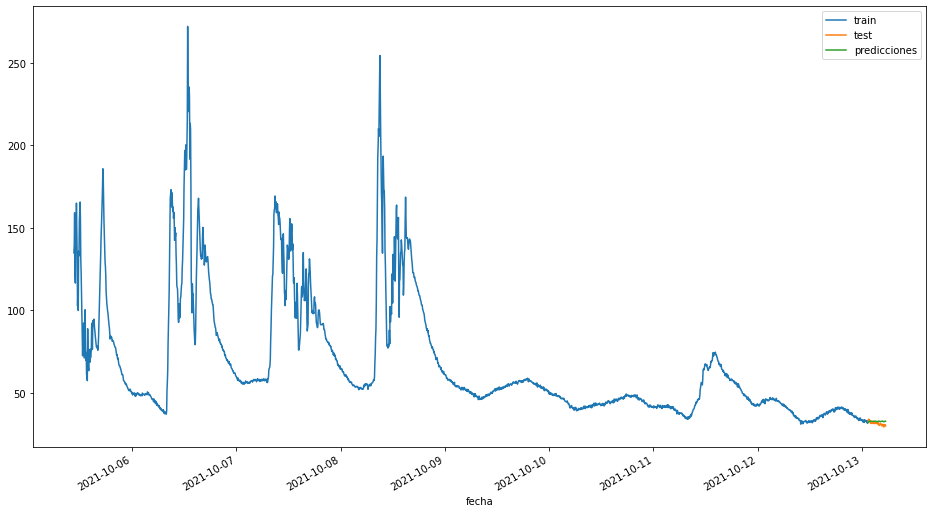

In [43]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 9))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();



In [45]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")



Error de test (mse): 2.717112894196999


# Tuning, HiperParametros del modelo 
El ForecasterAutoreg entrenado ha utilizado una ventana temporal de 6 lags y un modelo Random Forest con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados.

Para identificar la mejor combinación de lags e hiperparámetros, la librería skforecast dispone de la estrategia de validación cruzada temporal y de backtesting. Independientemente de la estrategia utilizada, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de overfitting. A continuación, se utiliza el primer 50% de observaciones de entrenamiento para el entrenamiento inicial y el segundo 50% para la comparación de los modelos.

In [48]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 12 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [10, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

2021-10-15 09:41:17,205 root       INFO  Number of models compared: 12
loop lags_grid: 100%|██████████████████████████████████████████████████████████████████| 2/2 [39:34<00:00, 1187.36s/it]
2021-10-15 10:20:51,939 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 100}



In [49]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",3.837700,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",3.947679,10,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",4.827765,5,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",4.862576,5,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",4.902534,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",4.919454,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",15.874623,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",17.935725,10,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",22.116592,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",22.158854,3,500


## Los mejores resultados se obtienen si se utiliza una ventana temporal de 10 lags y una configuración de random forest {'max_depth': 10, 'n_estimators': 100}.


In [50]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 10
                )

forecaster_rf.fit(y=datos_train)

In [51]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)



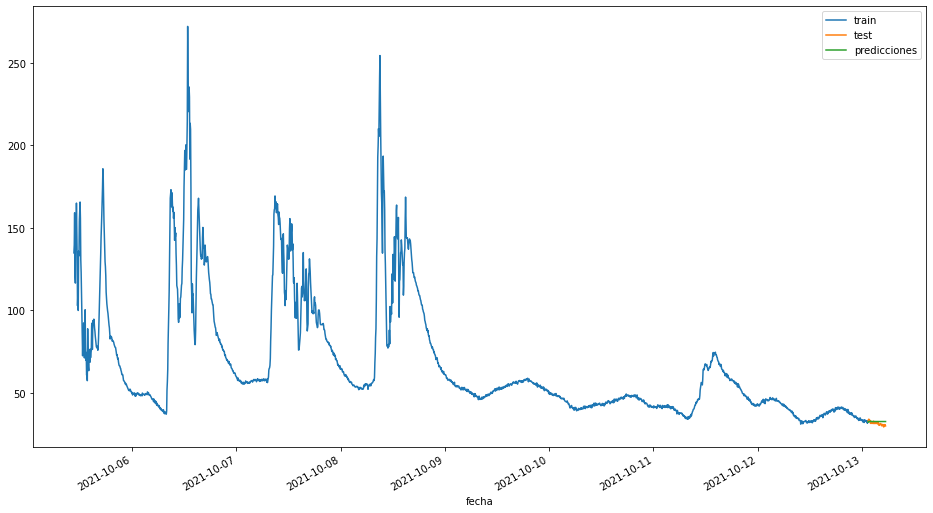

In [52]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 9))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();



In [54]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")



Error de test (mse) 2.4475667399359318
